<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.utils import shuffle
#from pymystem3 import Mystem
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
#import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
#!{sys.executable} -m spacy download en_core_web_sm
import spacy

from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 1.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
CV_COUNTS = 3

In [3]:
import random
np.random.seed(42)

In [4]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
(data.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
data.duplicated().sum()

0

In [7]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [8]:
data.sample(n=5)

,text,toxic
31055,"Sometime back, I just happened to log on to ww...",0
102929,"""\n\nThe latest edit is much better, don't mak...",0
67385,""" October 2007 (UTC)\n\nI would think you'd be...",0
81167,Thanks for the tip on the currency translation...,0
90182,I would argue that if content on the Con in co...,0


Проведем лемматизацию и отчистим тексты от лишних символов.

In [9]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
%%time
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

data['text'] = data['text'].apply(clear_text) 

CPU times: user 4.54 s, sys: 61.9 ms, total: 4.6 s
Wall time: 4.61 s


In [11]:
%%time
def get_wordnet(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,              
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = [lemmatizer.lemmatize(t, get_wordnet(t)) for t in nltk.word_tokenize(text)]
    return ' '.join(text)

data['text'] = data['text'].progress_apply(lemm_text) 

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 19min 15s, sys: 1min 54s, total: 21min 9s
Wall time: 21min 39s


In [12]:
data.sample(n=5)

,text,toxic
17234,murrumbidgee mean track go down here a very go...,0
65584,you just change the article after discussion d...,0
125277,there i get a little very little info on basic...,0
75724,block i have temporarily block your account fo...,0
14311,thanks for experiment with the page bonzi budd...,0


Список стоп-слов.

In [13]:
stopwords = set(nltk_stopwords.words('english'))

Проверим баланс классов.

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<AxesSubplot:>

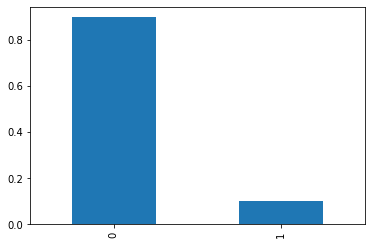

In [14]:
class_toxic = data['toxic'].value_counts(normalize=True)
print(class_toxic)
class_toxic.plot(kind='bar')

Мы наблюдаем жуткий дисбаланс. Далее сделаем веса классов сбалансированными с помощью 'class_weight='balanced'.

Разделим выборки на тестовую и обучающую 80/20.

In [15]:
target =data['toxic']
features = data.drop(['toxic'], axis=1)

features_train, features_test,  target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

In [16]:
print(features_train.shape)
print(features_test.shape)

(127433, 1)
(31859, 1)


In [17]:
print(target_train.shape)
print(target_test.shape)

(127433,)
(31859,)


Проведем изменения балансов классов.

In [18]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train_idf = count_tf_idf.fit_transform(features_train['text'])
features_test_idf = count_tf_idf.transform(features_test['text'])

print(features_train_idf.shape)
print(features_test_idf.shape)

(127433, 132080)
(31859, 132080)


In [19]:
%%time

model = LogisticRegression(random_state=42)
f1_original = cross_val_score(model, 
                      features_train_idf, 
                      target_train, 
                      cv=CV_COUNTS,
                      scoring='f1').mean()

print('F1 без балансировки', f1_original)

F1 без балансировки 0.7068430317934163
CPU times: user 1min 3s, sys: 1min 3s, total: 2min 7s
Wall time: 2min 8s


In [20]:
%%time

model = LogisticRegression(class_weight='balanced', random_state=42)
f1_ballanced = cross_val_score(model, 
                      features_train_idf, 
                      target_train, 
                      cv=CV_COUNTS, 
                      scoring='f1').mean()

print('F1 с балансированными классами', f1_ballanced)

F1 с балансированными классами 0.7442155376243416
CPU times: user 49.9 s, sys: 50.3 s, total: 1min 40s
Wall time: 1min 40s


F1 метрика значительно стала больше, дальше будет использовать этот метод балансирования.

## Обучение

Возьмем такие модели:
- LogisticRegression  
- LightGBM 
- CatBoost

In [21]:
%%time

params={'model__C': [0.1, 1, 10],
       'model__class_weight': ['balanced'],
       'model__random_state': [42],
       'model__max_iter': [200]}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True, stop_words=stopwords)),
    ('model', LogisticRegression())
])

grid_lr = GridSearchCV(estimator=pipeline, param_grid=params, cv=CV_COUNTS, scoring='f1', n_jobs=-1)
grid_lr.fit(features_train['text'], target_train)
lr_best_paramms = grid_lr.best_params_

print(lr_best_paramms)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

{'model__C': 10, 'model__class_weight': 'balanced', 'model__max_iter': 200, 'model__random_state': 42}
0.7710488923335953
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 sublinear_tf=True)),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=200,
                             

In [22]:
%%time
best_model = grid_lr.best_estimator_
target_predict = best_model.predict(features_train['text'])
f1_train_LR = f1_score(target_train, target_predict)

print('F1 на тренировочной LogisticRegression', f1_train_LR)

F1 на тренировочной LogisticRegression 0.9890722909980131
CPU times: user 19.9 s, sys: 122 ms, total: 20 s
Wall time: 20 s


In [23]:
%%time
params = {'model__verbose': [False],
        'model__iterations': [200],
        'model__random_state': [42],
        'model__class_weights':([(1, 1), (1, 11)])}
        
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('model', CatBoostClassifier())])
              
cb_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=CV_COUNTS, scoring='f1', n_jobs=-1)
cb_grid.fit(features_train['text'], target_train)
cb_best_paramms = cb_grid.best_params_

print(cb_best_paramms)
print(cb_grid.best_score_)
print(cb_grid.best_estimator_)

{'model__class_weights': (1, 1), 'model__iterations': 200, 'model__random_state': 42, 'model__verbose': False}
0.7393006726823788
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7facaa534d90>)])
CPU times: user 40min 5s, sys: 14.2 s, total: 40min 19s
Wall time: 40min 23s


In [24]:
%%time
cb_model = cb_grid.best_estimator_
target_predict = cb_model.predict(features_train['text'])
f1_train_CB = f1_score(target_train, target_predict)

print('F1 на тренировочной LogisticRegression', f1_train_CB)

F1 на тренировочной LogisticRegression 0.7850149760829719
CPU times: user 6.45 s, sys: 22 ms, total: 6.47 s
Wall time: 6.48 s


Логистическая регрессия оказалось самой шустрой и метрика F1 на тренировочной выборке равна 0.98. Значит ее и опробуем на тестовой выборке. 

In [25]:
%%time

target_predict = best_model.predict(features_test['text'])
f1_test_LR = f1_score(target_test, target_predict)

print('F1 на тестовой LogisticRegression', f1_test_LR)

F1 на тестовой LogisticRegression 0.7807294011706439
CPU times: user 4.17 s, sys: 0 ns, total: 4.17 s
Wall time: 4.18 s


In [26]:
print('Precision:', precision_score(target_test, target_predict))
print('Accuracy:', accuracy_score(target_test, target_predict))

Precision: 0.7591943957968477
Accuracy: 0.9541416868074956


## Выводы

Лучше всего подошла модель логистической регрессии, ее метрика F1 равна 0,78 на тестовой выборке. Также эта модель обладает большими показателями precision (точности) и accuracy, значит именно токсичные комментарии хорошо находятся этой моделью. 

Загрузили данные и провели их предобработку (лемматизацию, очитску текстов, удаление лишнего). Обучили две-три модели с разными гиперпараметрами, наилучшую подходящую модель проверили на тестовой выборке. 